### Define topology

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.optimize import fmin


from codes.utils import printoptions
from codes.graph_utils import Graph, spectral_gap


class TunableChain(Graph):

    def __init__(self, a, b, mixing, delta_max, p):
        self.a = a
        self.b = b
        self.delta_max = delta_max
        self.p = p

        if 0 > (1-a-b) - delta_max:
            raise NotImplementedError

        metropolis = np.zeros((5, 5))
        metropolis[1:, 1:] = mixing
        metropolis[1, 1] = 1 - 2*delta_max
        
        metropolis[1, 3] = delta_max
        metropolis[3, 1] = delta_max
        metropolis[3, 3] -= delta_max

        metropolis[1, 4] = delta_max
        metropolis[4, 1] = delta_max
        metropolis[4, 4] -= delta_max
    

        self.metropolis_weight = metropolis
    
    def get_neighbors_index(self, node, include_self):
        if node == 0:
            return [0, 2, 3] if include_self else [2, 3]
        
        if node == 1:
            return [1, 2] if include_self else [2] 
        
        if node == 2:
            return [0, 1, 2, 3] if include_self else [0, 1, 3]

        if node == 3:
            return [0, 2, 3, 4] if include_self else [0, 2, 4]
        
        if node == 4:
            return [3, 4] if include_self else [3]
        
        raise NotImplementedError

    def get_neighbors_weight(self, node, include_self): #wij given i, wij = wji
        indices = self.get_neighbors_index(node, include_self)
        weights = [self.metropolis_weight[node][j] for j in indices]
        return weights
    
    def get_good_neighbors_index(self, node, include_self):
        indices = self.get_neighbors_index(node, include_self)
        return [i for i in indices if i not in [0, 1]]

    def delta_i(self, good_node):
        return self.metropolis_weight[good_node, 0]


class DataManager(object):
    
    def __init__(self, data, graph, attacker):
        assert len(data) == 4

        self.good_data = data
        self.graph = graph
        self.attacker = attacker
        attacker.configure(self, graph)
    
    def getDataOn(self, node): #theta ji given i
        data = [self.attacker(0) + self.good_data]
        indices = self.graph.get_neighbors_index(node, include_self=True)
        return [data[i][node] for i in indices]

    def setGoodData(self, data):
        self.good_data = data

    def getGoodData(self, good_node):
        return self.good_data[good_node - 1]
    
    def getState(self): # array of theta i
        data = [self.attacker(0)] + self.good_data
        data = [data[i][i] for i in range(len(data))]
        return data
    
    def getGoodState(self): # array of theta i
        data = self.good_data
        data = [data[i][i] for i in range(len(data))]
        return data

# Attacks

In [3]:
class Attack(object):

    def configure(self, data_manager, graph):
        self.data_manager = data_manager
        self.graph = graph

    def __call__(self, byzantine_node):
        pass

## Jaggi's 

In [4]:
class ConstValueAttack(Attack):
    def __init__(self, v0, v1, n):
        self.v0 = [v0 for i in range(n)]
        self.n = n

    def __call__(self, byzantine_node):
        if byzantine_node == 0:
            return self.v0
        raise NotImplementedError

        
class DissensusAttack(Attack):

    def __init__(self, eps, n):
        self.eps = eps
        self.n = n

    def __call__(self, byzantine_node):
        data = self.data_manager.good_data  
        victim = 2
        if byzantine_node == 0:
            m = self.graph.metropolis_weight[2]
            v = m[1] * (data[1-1][2] - data[2-1][2]) + m[3] * (data[3-1][2] - data[2-1][2])
            v /= m[0]
            theta3 = data[2-1][2] - self.eps * v
            
            m = self.graph.metropolis_weight[4]
            v = m[2] * (data[2-1][3] - data[3-1][3]) + m[4] * (data[4-1][3] - data[3-1][3])
            v /= m[0]
            theta4 = data[1][3] - self.eps * v
            return [0, 0, theta3, theta4, 0]


        raise NotImplementedError
        

# Our own (added code)

## Non-Adaptive

In [5]:
class RandomAttack(Attack):
    def __init__(self, a, b, n):
        self.a = a
        self.b = b
        self.n = n
        
    def __call__(self, byzantine_node): 
        if byzantine_node == 0:
            return [float(random.randint(self.a, self.b)) for i in range(self.n)]
       
    
class RandomConsistentAttack(Attack):
    def __init__(self, a, b, n):
        self.a = a
        self.b = b
        self.n = n
        
    def __call__(self, byzantine_node): 
        if byzantine_node == 0:
            rand = float(random.randint(self.a, self.b))
            return [rand for i in range(self.n)]
        
        
class InconsistentAttack(Attack):
    def __init__(self, a, b, n):        
        self.v0 = [float(random.randint(a, b)) for i in range(n)]
        
    def __call__(self, byzantine_node): 
        if byzantine_node == 0:
            return self.v0
        raise NotImplementedError

## Adaptive

### State Override

In [6]:
class StateOverrideAttack(Attack):
    def __init__(self, target, n):        
        self.target = target
        self.n = n
        
    def __call__(self, byzantine_node): 
        thetas = [0] * self.n
        data = self.data_manager.good_data
        
        for i in range(1, self.n):
            
            m = self.graph.metropolis_weight[i]
            if m[byzantine_node] == 0:
                continue
                
            v = data[i-1][i]    
            tau = get_tau(data, self.graph, i)
            good_local_indices = self.graph.get_good_neighbors_index(i, include_self=False)
            
            network_contrib = 0
            for j in good_local_indices:
                vv = data[j-1][j]
                if vv == v:
                    network_contrib += vv*m[j]
                else:
                    network_contrib += (v + clip(vv - v, tau))*m[j]
                    
            thetas[i] = (self.target - network_contrib)/m[byzantine_node]
        return thetas

    
class TestStateOverrideAttack(Attack):
    def __init__(self, target, n):        
        self.target = target
        self.n = n
        
    def __call__(self, byzantine_node): 
        thetas = [0] * self.n
        data = self.data_manager.good_data
        
        for i in range(1, self.n):
            
            m = self.graph.metropolis_weight[i]
                
            v = data[i-1][i]    
            tau = get_tau(data, self.graph, i)
            good_local_indices = self.graph.get_neighbors_index(i, include_self=True)
            
            network_contrib = 0
            for j in good_local_indices:
                if j == byzantine_node:
                    continue
                    
                network_contrib += (v + clip(data[j-1][j] - v, tau))*m[j]
                    
            thetas[i] = (self.target - network_contrib)/m[byzantine_node]
        return thetas


In [6]:
#drafts

class StateOverrideWithoutClipAttack(Attack):
    def __init__(self, target, n):        
        self.target = target
        self.n = n
        
    def __call__(self, byzantine_node): 
        thetas = [0] * self.n
        data = self.data_manager.good_data
        for i in range(2, self.n):
            m = self.graph.metropolis_weight[i]
            if m[byzantine_node] == 0:
                continue
            thetas[i] = (self.target - sum([data[j-2][i]*m[j] for j in range(self.n)]))/m[byzantine_node]
        return thetas 
    
    
class StateOverrideWithoutClipNorDivAttack(Attack):
    def __init__(self, target, n):        
        self.target = target
        self.n = n
        
    def __call__(self, byzantine_node): 
        thetas = [0] * self.n
        data = self.data_manager.good_data
        for i in range(2, self.n):
            m = self.graph.metropolis_weight[i]
            thetas[i] = self.target - sum([data[j-2][i]*m[j] for j in range(self.n)])
        return thetas 
    
class StateOverrideAttackStupidClip(Attack):
    def __init__(self, target, n):        
        self.target = target
        self.n = n
        
    def __call__(self, byzantine_node): 
        thetas = [0] * self.n
        data = self.data_manager.good_data
        
        for i in range(2, self.n):
            v = data[i-2][i]
            m = self.graph.metropolis_weight[i]
            if m[byzantine_node] == 0:
                continue
            tau = get_tau(data, self.graph, i)
            network_contrib = 0
            for j in good_local_indices:
                vv = data[j-2][j]
                if vv == v:
                    network_contrib += vv*m[j]
                else:
                    network_contrib += (v + clip(vv - v, tau))*m[j]
            thetas[i] = (self.target - network_contrib)/m[byzantine_node]
        return thetas 
    
class OptiStateOverrideAttack(Attack):
    def __init__(self, target, n):        
        self.target = target
        self.n = n
        
    def __call__(self, byzantine_node): 
        thetas = [0] * self.n
        data = self.data_manager.good_data
        
        for i in range(2, self.n):
            v = data[i-2][i]
            m = self.graph.metropolis_weight[i]
            if m[byzantine_node] == 0:
                continue
                
            tau = get_tau(data, self.graph, i)
            good_local_indices = self.graph.get_good_neighbors_index(i, include_self=False)
            
            network_contrib = 0
            for j in good_local_indices:
                vv = data[j-2][j]
                if vv == v:
                    network_contrib += vv*m[j]
                else:
                    network_contrib += (v + clip(vv - v, tau))*m[j]
            
            def f(x):
                return abs(self.target - ((v + clip(x - v, tau))*m[byzantine_node] + network_contrib))
            
            thetas[i] = fmin(f, self.target, disp=False)[0]/m[byzantine_node]
        return thetas 

## SandTrap

In [7]:
#Both have interesting behoavior, to test in more graphs

class SandTrapAttack(Attack):

    def __init__(self, target, n):
        self.target = target
        self.n = n

    def __call__(self, byzantine_node):
        thetas = [0] * self.n
        data = self.data_manager.good_data
        
        for i in range(1, self.n):
            
            if self.graph.metropolis_weight[i][byzantine_node] == 0:
                continue
                
            tau = get_tau(data, self.graph, i)
            v = data[i-1][i]
            m = self.graph.metropolis_weight[i]
            
            t = self.target
            #m = self.graph.metropolis_weight[t]
            neighbors = self.graph.get_neighbors_index(t, include_self=True)
            
            # compute contribution of clipped network values
            w = 0
            for j in neighbors:
                if byzantine_node == j:
                    continue
                vv = data[j - 1][t]
                w += (v + clip(vv - v, tau))*m[j]
            
            if i == t:
                def compensate_contrib(x):    
                    return abs(w + (v + clip(x - v, tau))*m[byzantine_node])
                
                w = fmin(compensate_contrib, np.array(-100), disp=False)[0]
                
            thetas[i] = w/m[byzantine_node]
        return thetas
    
    
    
class GradSandTrapAttack(Attack):

    def __init__(self, target, n):
        self.target = target
        self.n = n

    def __call__(self, byzantine_node):
        thetas = [0] * self.n
        data = self.data_manager.good_data
        
        for i in range(1, self.n):
            
            if self.graph.metropolis_weight[i][byzantine_node] == 0:
                continue
                
            v = data[i-1][i]
            m = self.graph.metropolis_weight[i]
            
            t = self.target
            #m = self.graph.metropolis_weight[t]
            neighbors = self.graph.get_neighbors_index(t, include_self=True)
            
            # compute contribution of clipped network values
            w = 0
            for j in neighbors:
                if byzantine_node == j:
                    continue
                w += data[j - 1][t]*m[j]
            
            if i == t:
                w = -w
                
            thetas[i] = w/m[byzantine_node]
        return thetas

In [8]:
#drafts

class TerTestSandTrapAttack(Attack):

    def __init__(self, target, n):
        self.target = target
        self.n = n

    def __call__(self, byzantine_node):
        thetas = [0] * self.n
        data = self.data_manager.good_data
        
        for i in range(2, self.n):
            
            if self.graph.metropolis_weight[i][byzantine_node] == 0:
                continue
                
            tau = get_tau(data, self.graph, i)
            v = data[i-2][i]
            m = self.graph.metropolis_weight[i]
            
            t = self.target
            #m = self.graph.metropolis_weight[t]
            neighbors = self.graph.get_neighbors_index(t, include_self=True)
            if i != t:
                neighbors = self.graph.get_good_neighbors_index(t, include_self=True)
            
            # compute contribution of clipped network values
            w = 0
            for j in neighbors:
                if byzantine_node == j:
                    continue
                vv = data[j - 2][t]
                w += (v + clip(vv - v, tau))*m[j]
            
            if i == t:
                def compensate_contrib(x):    
                    return abs(w + (v + clip(x - v, tau))*m[byzantine_node])
                
                w = fmin(compensate_contrib, np.array(-100), disp=False)[0]
                
            thetas[i] = w/m[byzantine_node]
        return thetas
    
    
class TestGradTSandTrapAttack(Attack):

    def __init__(self, target, n):
        self.target = target
        self.n = n

    def __call__(self, byzantine_node):
        thetas = [0] * self.n
        data = self.data_manager.good_data
        
        for i in range(2, self.n):
            
            if self.graph.metropolis_weight[i][byzantine_node] == 0:
                continue
                
            t = self.target
            v = data[t-2][i]
            m = self.graph.metropolis_weight[t]
            
            
            #m = self.graph.metropolis_weight[t]
            neighbors = self.graph.get_neighbors_index(t, include_self=True)
            
            # compute contribution of clipped network values
            w = 0
            for j in neighbors:
                if byzantine_node == j:
                    continue
                w += data[j - 2][t]*m[j]
            
            if i == t:
                w = -w
                
            thetas[i] = w/m[byzantine_node]
        return thetas

    
class VintageSandTrapAttack(Attack):

    def __init__(self, target, n):
        self.target = target
        self.n = n

    def __call__(self, byzantine_node):
        thetas = [0] * self.n
        data = self.data_manager.good_data
        
        for i in range(2, self.n):
            
            if self.graph.metropolis_weight[i][byzantine_node] == 0:
                continue
                
            tau = get_tau(data, self.graph, i)
            v = data[i-2][i]
            m = self.graph.metropolis_weight[i]
            
            t = self.target
            #m = self.graph.metropolis_weight[t]
            good_local_indices = self.graph.get_good_neighbors_index(t, include_self=True)
            
            # compute contribution of clipped network values
            w = 0
            for j in good_local_indices:
                vv = data[j - 2][t]
                w += (v + clip(vv - v, tau))*m[j]
            
            if i == t:
                def compensate_contrib(x):    
                    return abs(w + (v + clip(x - v, tau))*m[byzantine_node])
                
                w = fmin(compensate_contrib, np.array(-100), disp=False)[0]
                
            thetas[i] = w/m[byzantine_node]
        return thetas
    

class TrueSandTrapAttack(Attack):

    def __init__(self, target, n):
        self.target = target
        self.n = n

    def __call__(self, byzantine_node):
        thetas = [0] * self.n
        data = self.data_manager.good_data
        
        for i in range(2, self.n):
            v = data[i-2][i]
            if self.graph.metropolis_weight[i][byzantine_node] == 0:
                continue
            t = self.target
            m = self.graph.metropolis_weight[t]
            good_local_indices = self.graph.get_good_neighbors_index(t, include_self=True)
        
            w = 0
            for j in good_local_indices:
                w += data[j - 2][t]*m[j]
            if i == t:
                w = -w
            thetas[i] = w/m[byzantine_node]
        return thetas
    
class FalseSandTrapAttack(Attack):

    def __init__(self, target, n):
        self.target = target
        self.n = n

    def __call__(self, byzantine_node):
        thetas = [0] * self.n
        data = self.data_manager.good_data
        
        for i in range(2, self.n):
            v = data[i-2][i]
            if self.graph.metropolis_weight[i][byzantine_node] == 0:
                continue
            t = self.target
            m = self.graph.metropolis_weight[t]
            good_local_indices = self.graph.get_good_neighbors_index(t, include_self=False)
        
            w = 0
            for j in good_local_indices:
                w += data[j - 2][t]*m[j]
            if i == t:
                w = -w
            thetas[i] = w/m[byzantine_node]
        return thetas
    
    
class OriginalSandTrapAttack(Attack):

    def __init__(self, target, n):
        self.target = target
        self.n = n

    def __call__(self, byzantine_node):
        thetas = [0] * self.n
        data = self.data_manager.good_data
        
        for i in range(2, self.n):
            v = data[i-2][i]
            m = self.graph.metropolis_weight[i]
            if m[byzantine_node] == 0:
                continue
            if i == self.target:
                v = -data[3-2][3]*m[3] - data[2-2][3]*m[2] - data[4-2][3]*m[4]
                thetas[i] = v/m[byzantine_node]
            else:
                v = data[3-2][3]*m[3] + data[2-2][3]*m[2] + data[4-2][3]*m[4]
                thetas[i] = v/m[byzantine_node]
        return thetas

    
class SandTrapAttackFalse(Attack):

    def __init__(self, target, n):
        self.target = target
        self.n = n

    def __call__(self, byzantine_node):
        thetas = [0] * self.n
        data = self.data_manager.good_data
        
        for i in range(2, self.n):
            v = data[i-2][i]
            m = self.graph.metropolis_weight[i]
            if m[byzantine_node] == 0:
                continue
                
            tau = get_tau(data, self.graph, i)
            
            v = data[i-2][i]
            if self.graph.metropolis_weight[i][byzantine_node] == 0:
                continue
            t = self.target
            m = self.graph.metropolis_weight[t]
            good_local_indices = self.graph.get_good_neighbors_index(t, include_self=False)
            
            # compute contribution of network by clipping values
            w = 0
            for j in good_local_indices:
                vv = data[j - 2][t]
                w += (v + clip(vv - v, tau))*m[j]
            
            def compensate_contrib(x):    
                return abs(w + (v + clip(x - v, tau))*m[byzantine_node])
            
            if i == t:
                w = fmin(compensate_contrib, np.array(-100), disp=False)[0]
                
            thetas[i] = w/m[byzantine_node]
        return thetas
    
    
class SandTrapWithoutVAttack(Attack):

    def __init__(self, target, n):
        self.target = target
        self.n = n

    def __call__(self, byzantine_node):
        thetas = [0] * self.n
        data = self.data_manager.good_data
        
        for i in range(2, self.n):
            v = data[i-2][i]
            m = self.graph.metropolis_weight[i]
            if m[byzantine_node] == 0:
                continue
                
            tau = get_tau(data, self.graph, i)
             
            if self.graph.metropolis_weight[i][byzantine_node] == 0:
                continue
            t = self.target
            m = self.graph.metropolis_weight[t]
            good_local_indices = self.graph.get_good_neighbors_index(t, include_self=True)
            
            # compute contribution of network by clipping values
            w = 0
            for j in good_local_indices:
                vv = data[j - 2][t]
                w += clip(vv - v, tau)*m[j]
            
            def compensate_contrib(x):    
                return abs(w + clip(x - v, tau)*m[byzantine_node])
            
            if i == t:
                w = fmin(compensate_contrib, np.array(-100), disp=False)[0]
                
            thetas[i] = w/m[byzantine_node]
        return thetas

class SandTrapMinusVAttack(Attack):

    def __init__(self, target, n):
        self.target = target
        self.n = n

    def __call__(self, byzantine_node):
        thetas = [0] * self.n
        data = self.data_manager.good_data
        
        for i in range(2, self.n):
            if self.graph.metropolis_weight[i][byzantine_node] == 0:
                continue
                
            tau = get_tau(data, self.graph, i)
            v = data[i-2][i]

            t = self.target
            m = self.graph.metropolis_weight[t]
            good_local_indices = self.graph.get_good_neighbors_index(t, include_self=True)
            
            # compute contribution of clipped network values
            w = 0
            for j in good_local_indices:
                vv = data[j - 2][t]
                w += (v + clip(vv - v, tau))*m[j]
            
            def compensate_contrib(x):    
                return abs(w + (v + clip(x - v, tau))*m[byzantine_node] -v)
            
            if i == t:
                w = fmin(compensate_contrib, np.array(-100), disp=False)[0]
                
            thetas[i] = w/m[byzantine_node]
        return thetas
    
    
class SandTrapMinusVWithTAttack(Attack):

    def __init__(self, target, n):
        self.target = target
        self.n = n

    def __call__(self, byzantine_node):
        thetas = [0] * self.n
        data = self.data_manager.good_data
        
        for i in range(2, self.n):
            if self.graph.metropolis_weight[i][byzantine_node] == 0:
                continue
                
            t = self.target
            tau = get_tau(data, self.graph, t)
            v = data[i-2][t]
            m = self.graph.metropolis_weight[t]
            good_local_indices = self.graph.get_good_neighbors_index(t, include_self=True)
            
            # compute contribution of clipped network values
            w = 0
            for j in good_local_indices:
                vv = data[j - 2][t]
                w += (clip(vv - v, tau))*m[j]
            
            def compensate_contrib(x):    
                return abs((clip(x - v, tau))*m[byzantine_node] - w)
            
            if i == t:
                w = fmin(compensate_contrib, np.array(-100), disp=False)[0]
                
            thetas[i] = w
        return thetas
    

class TFocussedSandTrapAttack(Attack):

    def __init__(self, target, n):
        self.target = target
        self.n = n

    def __call__(self, byzantine_node):
        thetas = [0] * self.n
        data = self.data_manager.good_data
        
        t = self.target
        tau = get_tau(data, self.graph, t)
        m = self.graph.metropolis_weight[t]
        good_local_indices = self.graph.get_good_neighbors_index(t, include_self=True)

        # compute contribution of clipped network values
        w = 0
        v = data[t-2][t]
        for j in good_local_indices:
            vv = data[j - 2][t]
            w += (v + clip(vv - v, tau))*m[j]

        def compensate_contrib(x):    
            return abs(w + (v + clip(x - v, tau))*m[byzantine_node])
        
        for i in range(2, self.n):
            if self.graph.metropolis_weight[i][byzantine_node] == 0:
                continue
            
            if i == t:
                w = fmin(compensate_contrib, np.array(-100), disp=False)[0]
                
            thetas[i] = w/m[byzantine_node]
        return thetas



## Echo

In [9]:

class EchoAttack(Attack):

    def __init__(self, s, c, n):
        self.s = s
        self.n = n
        self.c = c

    def __call__(self, byzantine_node):
        victim = 2
        
        data = self.data_manager.good_data   
        m3 = self.graph.metropolis_weight[2]
        # send sum (theta3 - neighbor_contrib)*weight contrib to victim
        v = data[2-1][2]*m3[2] + self.c*((data[2-1][2]-data[1-1][2])*m3[1] + (data[2-1][2] - data[3-1][2])*m3[3])
        #v = data[3-2][3]*m[3] + self.c*(-data[2-2][3]*m[2] -data[4-2][3]*m[4])
        
        m4 = self.graph.metropolis_weight[3]
        # send ( sum (neighbor_contrib - theta3)*weight contrib ) to neighbors of 3 (i.e. 4)
        w = -(data[2-1][3]*m4[2] + self.s*((data[2-1][3]-data[4-1][3])*m4[4]))
        
        if byzantine_node == 0:
            v /= m3[0]
            theta3 = v
            
            w /= m4[0] 
            theta4 = w
            return [0, 0, theta3, theta4, 0]

        raise NotImplementedError

In [10]:
class Experiment(object):

    def __init__(self, data_manager, graph, n, b, p, delta_max, T):
        # Number of workers
        self.n = n
        # Number of Byzantine workers
        self.b = b
        self.p = p
        self.delta_max = delta_max
        self.T = T

        self.data_manager = data_manager
        self.graph = graph
        data = self.data_manager.getGoodState()
        self.mu0 = sum(data) / len(data)

        self.consensus_distances = []
        self.errors = []

    def consensus_distance(self):
        data = self.data_manager.getGoodState()
        mu = sum(data) / len(data)
        return sum((i - mu) ** 2 for i in data) / len(data)

    def error(self):
        data = self.data_manager.getGoodState()
        return sum((i - self.mu0) ** 2 for i in data) / len(data)

    def run(self):
        self.consensus_distances.append(self.consensus_distance())
        self.errors.append(self.error())
        for t in range(self.T):
            new_data = []
            for i in range(self.b, self.n):
                # Aggregation on good worker i
                new_data.append(self.agg(i))
            self.data_manager.setGoodData(new_data)
            self.consensus_distances.append(self.consensus_distance())
            self.errors.append(self.error())

    def agg(self, i):
        raise NotImplementedError



# SSClip
def clip(v, tau):
    v_norm = abs(v)
    if v_norm == 0:
        return 0
    scale = min(1, tau / v_norm)
    return v * scale

def get_tau(data, graph, i):
    delta_i = graph.delta_i(i)
    good_local_indices = graph.get_good_neighbors_index(i, include_self=True)
    tau = 0
    v = data[i-1][i]
    m = graph.metropolis_weight[i]
    for j in good_local_indices:
        w = m[j]
        d = data[j-1][j]
        distance = (d - v) ** 2
        tau += w * distance

    if delta_i == 0:
        tau = np.inf
    else:
        tau /= delta_i
        tau = np.sqrt(tau)
    return tau

class SSClip(Experiment):

    def agg(self, i):
        data = self.data_manager.getState()
        v = data[i]

        delta_i = self.graph.delta_i(i)
        good_local_indices = self.graph.get_good_neighbors_index(i, include_self=False)

        tau = 0
        for j in good_local_indices:
            w = self.graph.metropolis_weight[i][j]
            d = data[j]
            distance = (d - v) ** 2
            tau += w * distance
        
        if delta_i == 0:
            tau = np.inf
        else:
            tau /= delta_i
            tau = np.sqrt(tau)
        
        #print("tau", tau)

        local_data = self.data_manager.getDataOn(i) #attacker updates here
        weights = self.graph.get_neighbors_weight(i, include_self=True)
        new_data = 0
        a = []
        for index, vv, w in zip(self.graph.get_neighbors_index(i, include_self=True), local_data, weights):
            if vv == v:
                z = v
            else:
                z = v + clip(vv - v, tau)
            new_data += w * z
            a.append(f"Clip node {index} from {vv} to {z}")
        
        return [new_data for i in range(self.n)]



## Tests

In [12]:
N = 5
b = 1
data0 = [[0 for i in range(N)], [0 for i in range(N)], [200 for i in range(N)], [200 for i in range(N)]]

a = 1 / 3
results = []
target = -100
for attacker, attack_name in [(TestStateOverrideAttack(target, N), "test"), (StateOverrideAttack(target, N), "original")]:
    Defense, defense_name = SSClip, "SSClip"
    for delta_max in [0.05]:#, 0.1, 0.2, 0.3, 0.4, 0.5]:
        for beta in [0.08]:#, 0.45, 0.35, 0.267, 0.19, 0.12, 0.08, 0.04, 0.02, 0.01, 1e-3]:
            mixing = np.array([
                [1-a, a, 0, 0],
                [a, 1-a-beta, beta, 0],
                [0, beta, 1-a-beta, a],
                [0, 0, a, 1-a]
            ])
            p = spectral_gap(mixing) ** 2
        
            graph = TunableChain(a, beta, mixing, delta_max=delta_max, p=p)
            data_manager = DataManager(data0, graph, attacker)
            runner = Defense(data_manager, graph, N, b, p, delta_max, 100)
            runner.run()
            results.append({"exp": runner, "attack": attack_name, "defense": defense_name, 'beta': beta})


/var/folders/h4/dsx18qqn0nv5bs61qjpy1c9h0000gp/T/ipykernel_74723/1768303320.py:56: RuntimeWarning: divide by zero encountered in double_scalars
  thetas[i] = (self.target - network_contrib)/m[byzantine_node]


IndexError: list index out of range

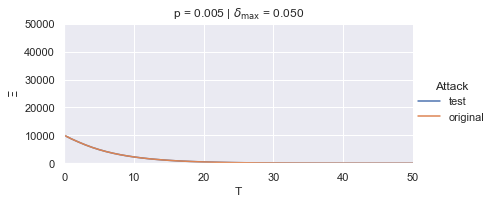

In [12]:
import pandas as pd
import seaborn as sns
stats = []
for res in results:
    delta_max, p = res['exp'].delta_max, res['exp'].p
    if delta_max > 0.3 or res['beta'] > 0.268 or res['beta'] < 0.08:
        continue

    for t, e, cd in zip(range(res['exp'].T+1), res['exp'].errors, res['exp'].consensus_distances):
        if t > 100:
            break
        stats.append({r"$\delta_{\max}$ value": delta_max, "p_value": p, "Error": e, r"$\Xi$": cd, "T": t, "Attack": res['attack']})


plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 11
sns.set(rc={'figure.figsize': (50, 10)})

df = pd.DataFrame(stats)
df['p'] = df['p_value'].apply(lambda x: "{:.3f}".format(x))
df[r"$\delta_{\max}$"] = df[r"$\delta_{\max}$ value"].apply(lambda x: "{:.3f}".format(x))
g = sns.relplot(data=df, x="T", y=r"$\Xi$", col=r"$\delta_{\max}$", row="p", kind='line', hue="Attack", height=3, aspect=2)

g.set(xlim=(0, 50))
g.set(ylim=(0, 50000))
# g.savefig("./consensus_constant_attack.pdf", bbox_inches="tight", dpi=720)

In [13]:
N = 6
b = 2
data0 = [[0 for i in range(N)], [0 for i in range(N)], [200 for i in range(N)], [200 for i in range(N)]]

a = 1 / 3
results = []
target = 3
for attacker, attack_name in [(TestStateOverrideAttack(target, N), "test"), (StateOverrideAttack(target, N), "original")]:
    Defense, defense_name = SSClip, "SSClip"
    for delta_max in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]:
        for beta in [0.58, 0.45, 0.35, 0.267, 0.19, 0.12, 0.08, 0.04, 0.02, 0.01, 1e-3]:
            mixing = np.array([
                [1-a, a, 0, 0],
                [a, 1-a-beta, beta, 0],
                [0, beta, 1-a-beta, a],
                [0, 0, a, 1-a]
            ])
            p = spectral_gap(mixing) ** 2
            try:
                graph = TunableChain(a, beta, mixing, delta_max=delta_max, p=p)
                data_manager = DataManager(data0, graph, attacker)
                runner = Defense(data_manager, graph, N, b, p, delta_max, 100)
                runner.run()
                results.append({"exp": runner, "attack": attack_name, "defense": defense_name, 'beta': beta})
            except:
                pass

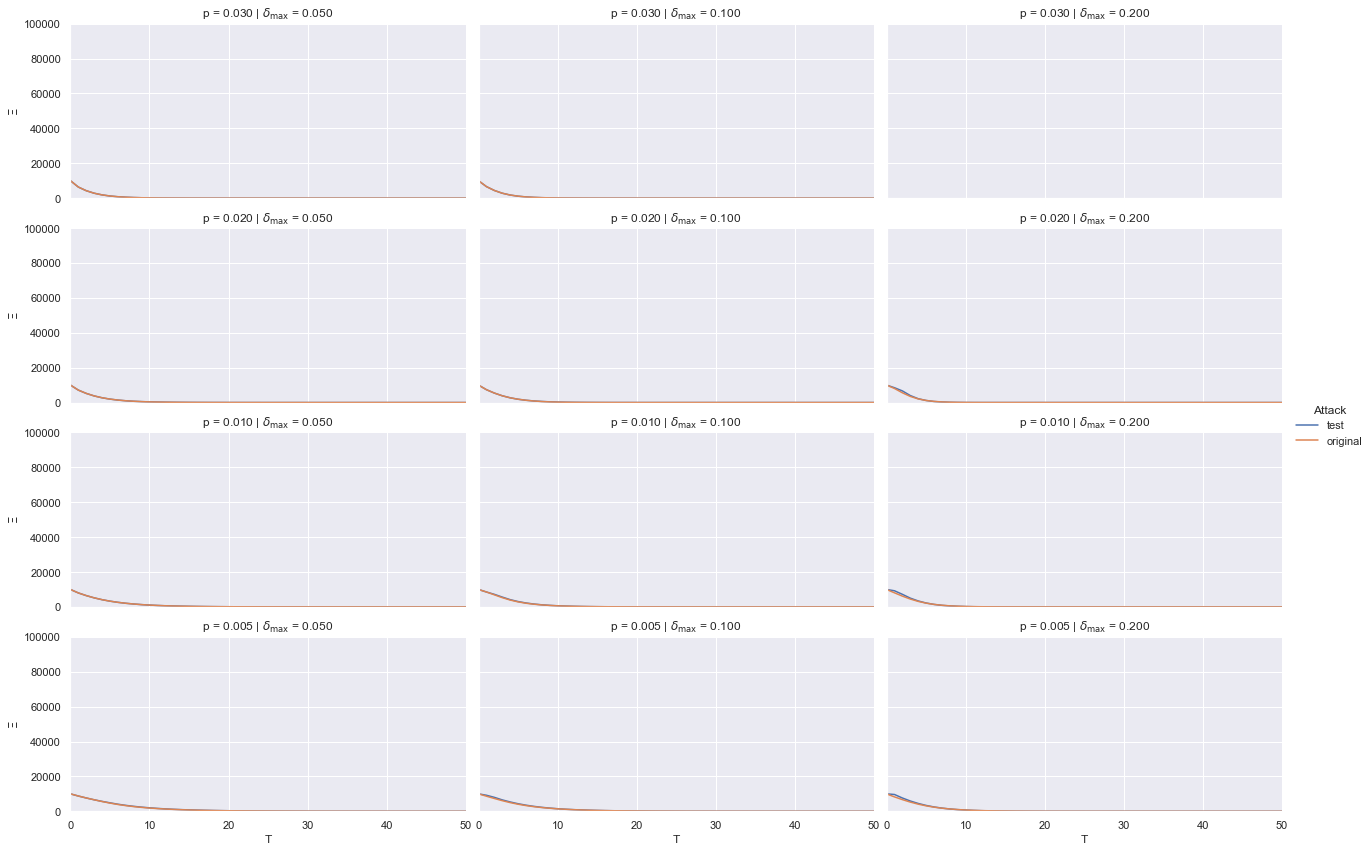

In [14]:
import pandas as pd
import seaborn as sns
stats = []
for res in results:
    delta_max, p = res['exp'].delta_max, res['exp'].p
    if delta_max > 0.3 or res['beta'] > 0.268 or res['beta'] < 0.08:
        continue

    for t, e, cd in zip(range(res['exp'].T+1), res['exp'].errors, res['exp'].consensus_distances):
        if t > 100:
            break
        stats.append({r"$\delta_{\max}$ value": delta_max, "p_value": p, "Error": e, r"$\Xi$": cd, "T": t, "Attack": res['attack']})


plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 11
sns.set(rc={'figure.figsize': (6.75, 3)})

df = pd.DataFrame(stats)
df['p'] = df['p_value'].apply(lambda x: "{:.3f}".format(x))
df[r"$\delta_{\max}$"] = df[r"$\delta_{\max}$ value"].apply(lambda x: "{:.3f}".format(x))
g = sns.relplot(data=df, x="T", y=r"$\Xi$", col=r"$\delta_{\max}$", row="p", kind='line', hue="Attack", height=3, aspect=2)

g.set(xlim=(0, 50))
g.set(ylim=(0, 100000))
# g.savefig("./consensus_constant_attack.pdf", bbox_inches="tight", dpi=720)

# Plots

## Non adaptive attacks

In [13]:
N = 5
b = 1
data0 = [[0 for i in range(N)], [0 for i in range(N)], [200 for i in range(N)], [200 for i in range(N)]]

a = 1 / 3
results = []
for attacker, attack_name in [(ConstValueAttack(0, 200, N), "constant"), 
                              (RandomAttack(-200,200, N), "random"), 
                              (RandomConsistentAttack(-200,200,N), "consistent"),
                              (InconsistentAttack(-200, 200, N), "inconsistent")]:
    Defense, defense_name = SSClip, "SSClip"
    for delta_max in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]:
        for beta in [0.58, 0.45, 0.35, 0.267, 0.19, 0.12, 0.08, 0.04, 0.02, 0.01, 1e-3]:
            mixing = np.array([
                [1-a, a, 0, 0],
                [a, 1-a-beta, beta, 0],
                [0, beta, 1-a-beta, a],
                [0, 0, a, 1-a]
            ])
            p = spectral_gap(mixing) ** 2
            try:
                graph = TunableChain(a, beta, mixing, delta_max=delta_max, p=p)
                data_manager = DataManager(data0, graph, attacker)
                runner = Defense(data_manager, graph, N, b, p, delta_max, 100)
                runner.run()
                results.append({"exp": runner, "attack": attack_name, "defense": defense_name, 'beta': beta})
            except:
                pass


In [14]:
import pandas as pd
import seaborn as sns
stats = []
for res in results:
    delta_max, p = res['exp'].delta_max, res['exp'].p
    if delta_max > 0.3 or res['beta'] > 0.268 or res['beta'] < 0.08:
        continue

    for t, e, cd in zip(range(res['exp'].T+1), res['exp'].errors, res['exp'].consensus_distances):
        if t > 100:
            break
        stats.append({r"$\delta_{\max}$ value": delta_max, "p_value": p, "Error": e, r"$\Xi$": cd, "T": t, "Attack": res['attack']})


plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 11
sns.set(rc={'figure.figsize': (6.75, 3)})

df = pd.DataFrame(stats)
df['p'] = df['p_value'].apply(lambda x: "{:.3f}".format(x))
df[r"$\delta_{\max}$"] = df[r"$\delta_{\max}$ value"].apply(lambda x: "{:.3f}".format(x))
g = sns.relplot(data=df, x="T", y=r"$\Xi$", col=r"$\delta_{\max}$", row="p", kind='line', hue="Attack", height=3, aspect=2)

g.set(xlim=(0, 100))
g.set(ylim=(0, 5000))
# g.savefig("./consensus_constant_attack.pdf", bbox_inches="tight", dpi=720)

KeyError: 'p_value'

## Adaptive attacks

In [17]:
N = 6
b = 2
data0 = [[0 for i in range(N)], [0 for i in range(N)], [200 for i in range(N)], [200 for i in range(N)]]

a = 1 / 3
results = []
for attacker, attack_name in [(EchoAttack(1, 1, N), "echo"), 
                              (StateOverrideAttack(-100, N), "override"), (SandTrapAttack(3, N), "sandtrap")
                             ,(DissensusAttack(1, N), "dissensus")]:
    Defense, defense_name = SSClip, "SSClip"
    for delta_max in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]:
        for beta in [0.58, 0.45, 0.35, 0.267, 0.19, 0.12, 0.08, 0.04, 0.02, 0.01, 1e-3]:
            mixing = np.array([
                [1-a, a, 0, 0],
                [a, 1-a-beta, beta, 0],
                [0, beta, 1-a-beta, a],
                [0, 0, a, 1-a]
            ])
            p = spectral_gap(mixing) ** 2
            try:
                graph = TunableChain(a, beta, mixing, delta_max=delta_max, p=p)
                data_manager = DataManager(data0, graph, attacker)
                runner = Defense(data_manager, graph, N, b, p, delta_max, 100)
                runner.run()
                results.append({"exp": runner, "attack": attack_name, "defense": defense_name, 'beta': beta})
            except:
                pass


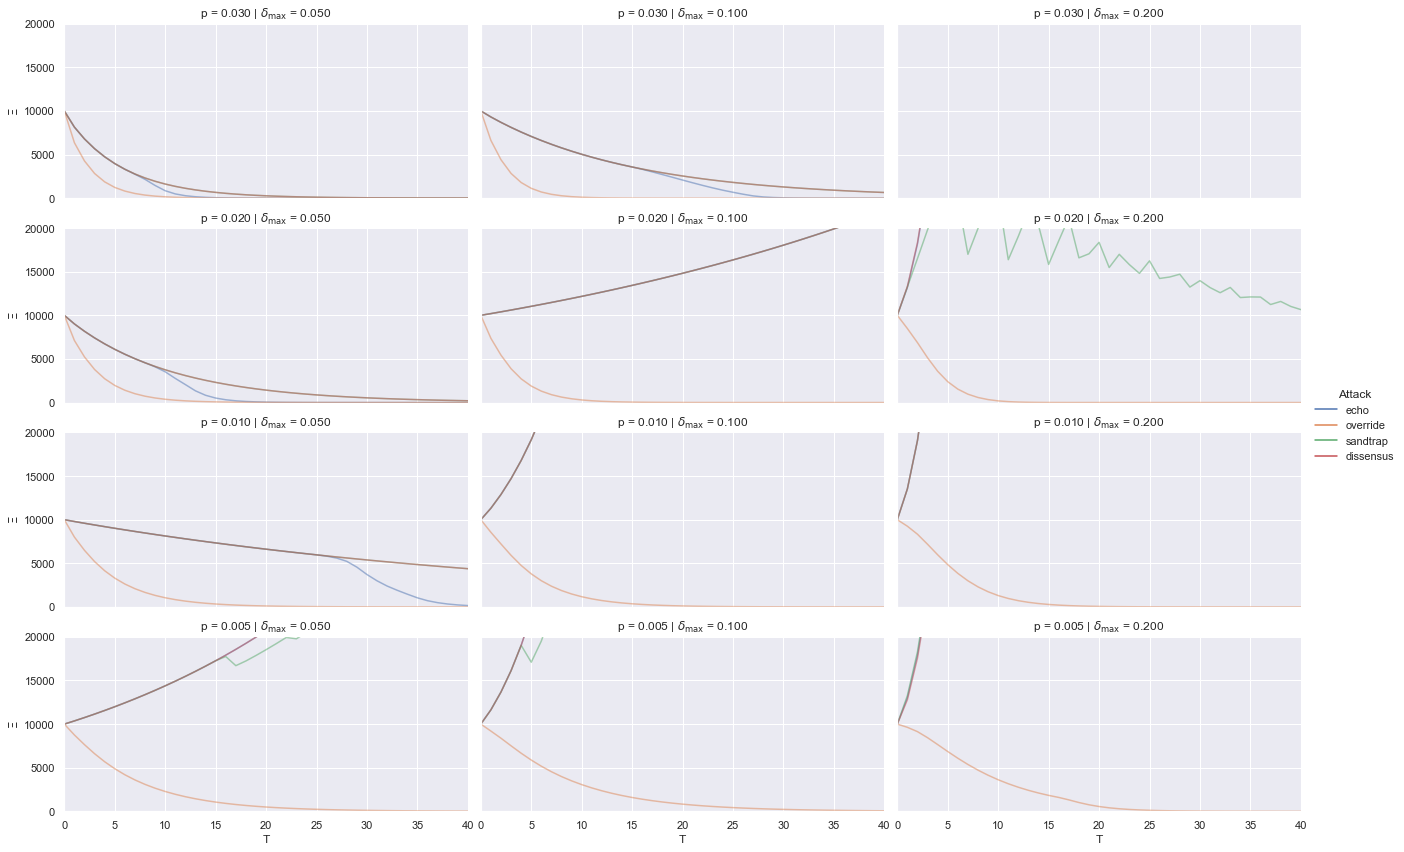

In [18]:
import pandas as pd
import seaborn as sns
stats = []
for res in results:
    delta_max, p = res['exp'].delta_max, res['exp'].p
    if delta_max > 0.3 or res['beta'] > 0.268 or res['beta'] < 0.08:
        continue

    for t, e, cd in zip(range(res['exp'].T+1), res['exp'].errors, res['exp'].consensus_distances):
        if t > 100:
            break
        stats.append({r"$\delta_{\max}$ value": delta_max, "p_value": p, "Error": e, r"$\Xi$": cd, "T": t, "Attack": res['attack']})


plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 11
sns.set(rc={'figure.figsize': (6.75, 3)})

df = pd.DataFrame(stats)
df['p'] = df['p_value'].apply(lambda x: "{:.3f}".format(x))
df[r"$\delta_{\max}$"] = df[r"$\delta_{\max}$ value"].apply(lambda x: "{:.3f}".format(x))
g = sns.relplot(data=df, x="T", y=r"$\Xi$", col=r"$\delta_{\max}$", row="p", kind='line', hue="Attack",
                alpha=0.5, height=3, aspect=2)

g.set(xlim=(0, 40))
g.set(ylim=(0, 20000))
# g.savefig("./consensus_constant_attack.pdf", bbox_inches="tight", dpi=720)

## In another order to see overlap

In [19]:
N = 6
b = 2
data0 = [[0 for i in range(N)], [0 for i in range(N)], [200 for i in range(N)], [200 for i in range(N)]]

a = 1 / 3
results = []
for attacker, attack_name in [(DissensusAttack(1, N), "dissensus"), (EchoAttack(1, 1, N), "echo"), 
                              (StateOverrideAttack(-100, N), "override"), (SandTrapAttack(3, N), "sandtrap")]:
    Defense, defense_name = SSClip, "SSClip"
    for delta_max in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]:
        for beta in [0.58, 0.45, 0.35, 0.267, 0.19, 0.12, 0.08, 0.04, 0.02, 0.01, 1e-3]:
            mixing = np.array([
                [1-a, a, 0, 0],
                [a, 1-a-beta, beta, 0],
                [0, beta, 1-a-beta, a],
                [0, 0, a, 1-a]
            ])
            p = spectral_gap(mixing) ** 2
            try:
                graph = TunableChain(a, beta, mixing, delta_max=delta_max, p=p)
                data_manager = DataManager(data0, graph, attacker)
                runner = Defense(data_manager, graph, N, b, p, delta_max, 100)
                runner.run()
                results.append({"exp": runner, "attack": attack_name, "defense": defense_name, 'beta': beta})
            except:
                pass


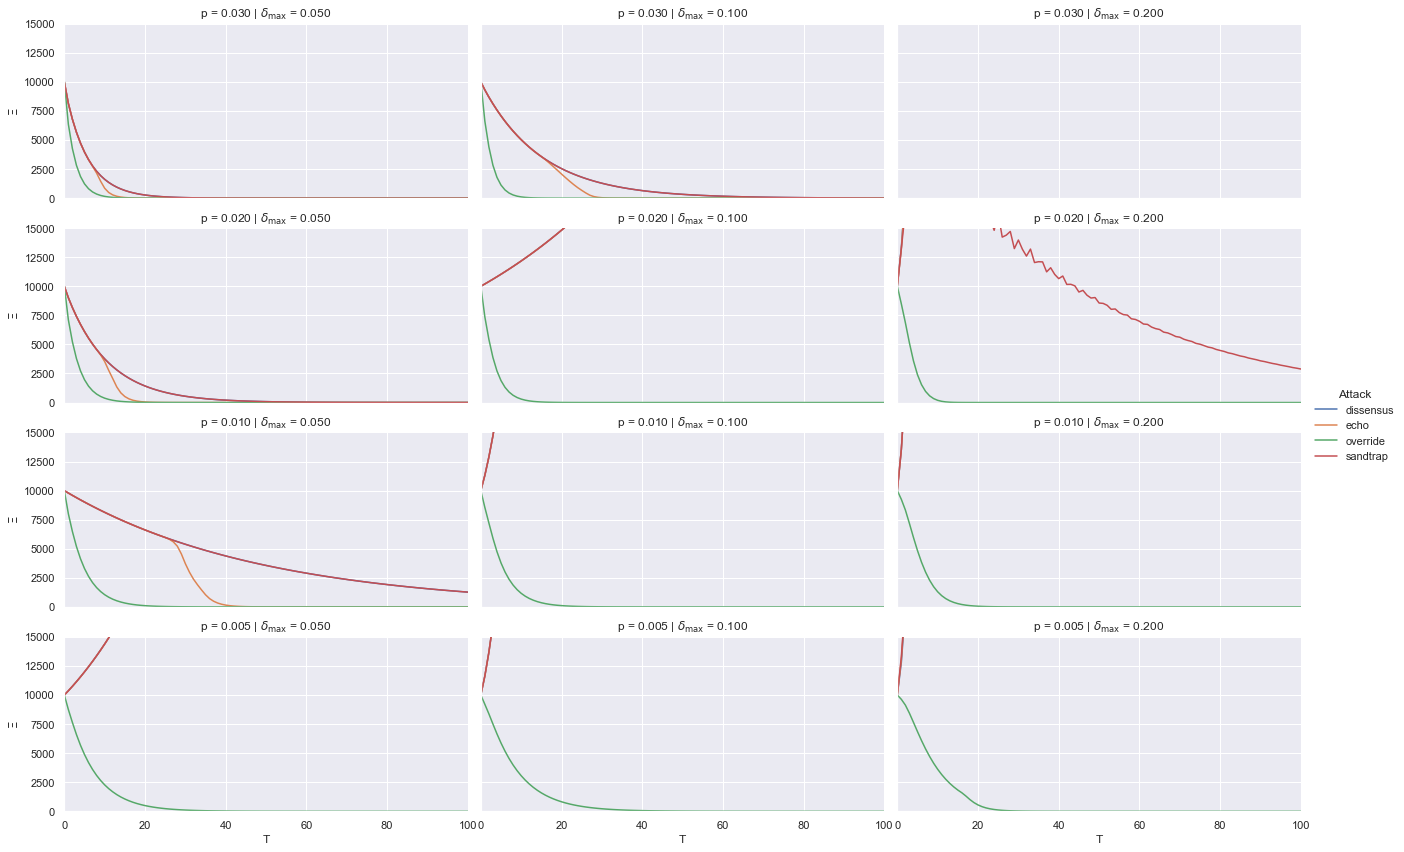

In [20]:
import pandas as pd
import seaborn as sns
stats = []
for res in results:
    delta_max, p = res['exp'].delta_max, res['exp'].p
    if delta_max > 0.3 or res['beta'] > 0.268 or res['beta'] < 0.08:
        continue

    for t, e, cd in zip(range(res['exp'].T+1), res['exp'].errors, res['exp'].consensus_distances):
        if t > 100:
            break
        stats.append({r"$\delta_{\max}$ value": delta_max, "p_value": p, "Error": e, r"$\Xi$": cd, "T": t, "Attack": res['attack']})


plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 11
sns.set(rc={'figure.figsize': (6.75, 3)})

df = pd.DataFrame(stats)
df['p'] = df['p_value'].apply(lambda x: "{:.3f}".format(x))
df[r"$\delta_{\max}$"] = df[r"$\delta_{\max}$ value"].apply(lambda x: "{:.3f}".format(x))
g = sns.relplot(data=df, x="T", y=r"$\Xi$", col=r"$\delta_{\max}$", row="p", kind='line', hue="Attack", height=3, aspect=2)

g.set(xlim=(0, 100))
g.set(ylim=(0, 15000))
# g.savefig("./consensus_constant_attack.pdf", bbox_inches="tight", dpi=720)

## Zoom

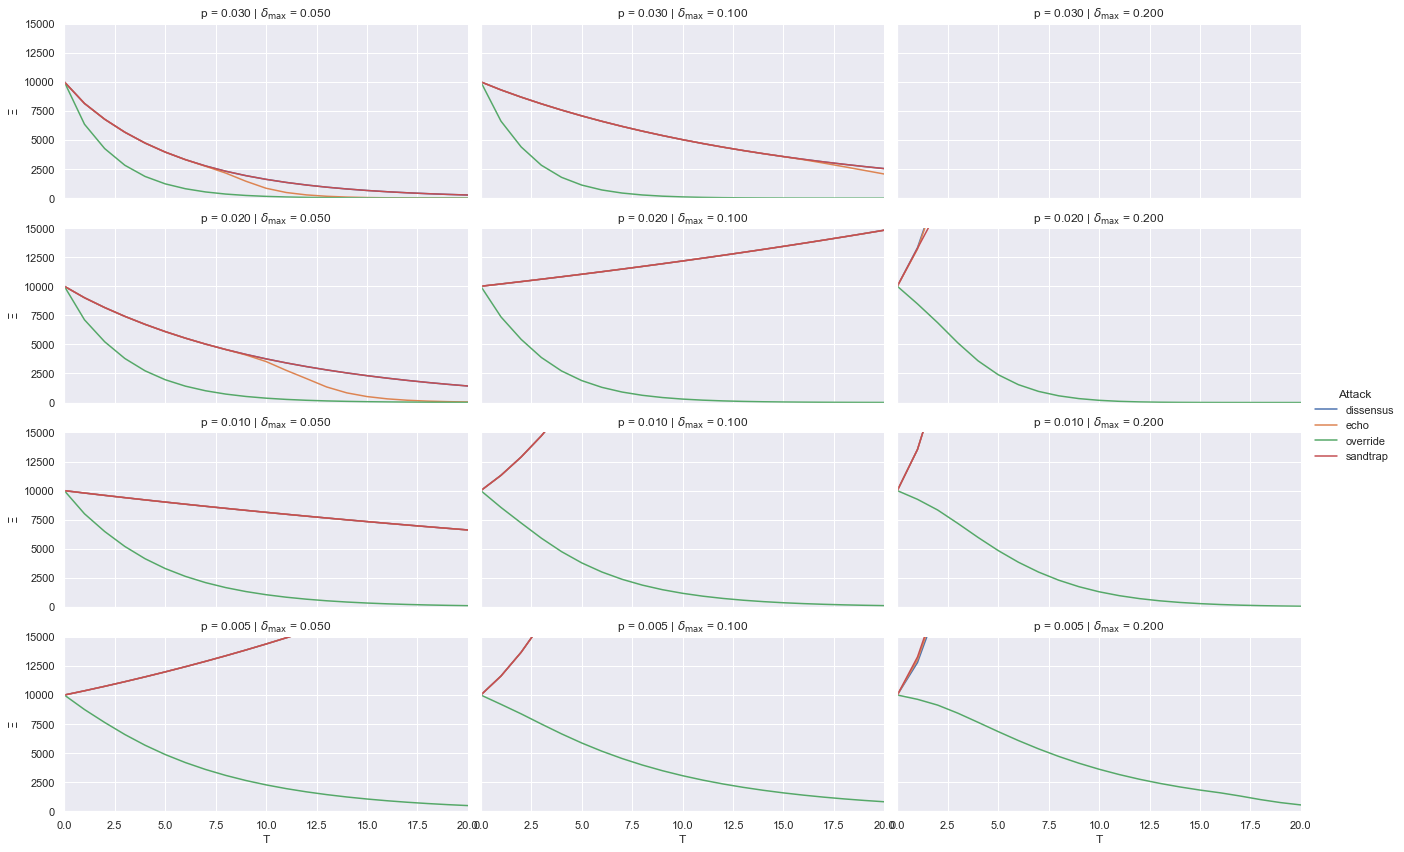

In [21]:
g = sns.relplot(data=df, x="T", y=r"$\Xi$", col=r"$\delta_{\max}$", row="p", kind='line', hue="Attack", height=3, aspect=2)

g.set(xlim=(0, 20))
g.set(ylim=(0, 15000))
# g.savefig("./consensus_constant_attack.pdf", bbox_inches="tight", dpi=720)

#### Same code without the continue condition on delta and beta

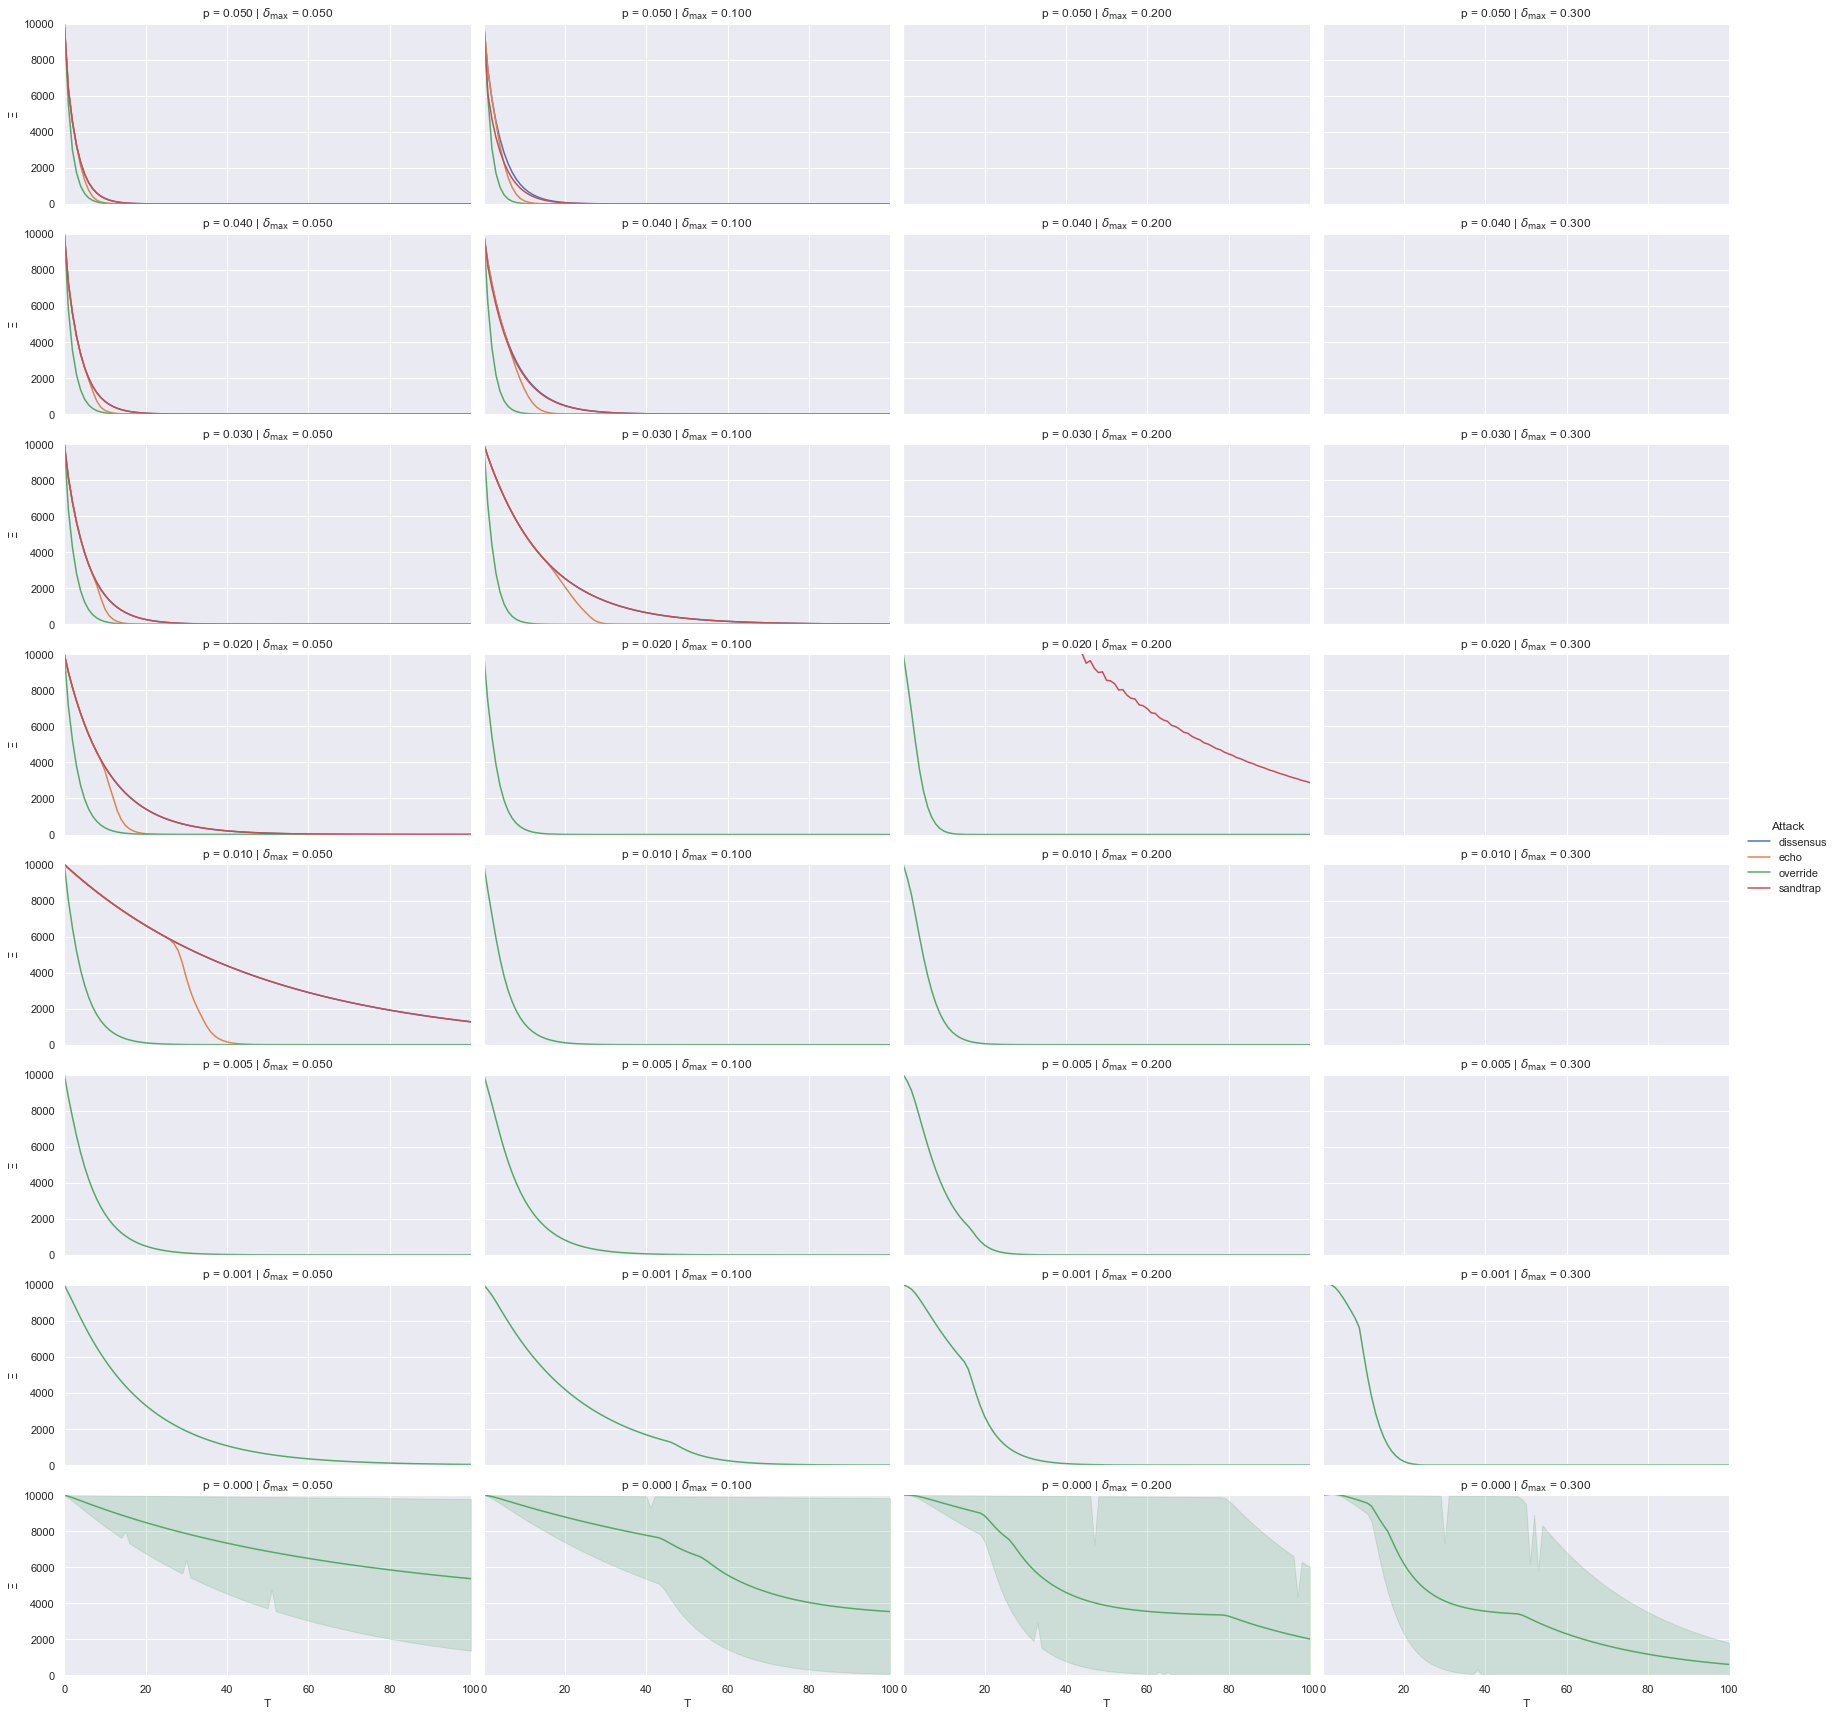

In [22]:
import pandas as pd
import seaborn as sns
stats = []
for res in results:
    delta_max, p = res['exp'].delta_max, res['exp'].p

    for t, e, cd in zip(range(res['exp'].T+1), res['exp'].errors, res['exp'].consensus_distances):
        if t > 100:
            break
        stats.append({r"$\delta_{\max}$ value": delta_max, "p_value": p, "Error": e, r"$\Xi$": cd, "T": t, "Attack": res['attack']})


plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 11
sns.set(rc={'figure.figsize': (6.75, 3)})

df = pd.DataFrame(stats)
df['p'] = df['p_value'].apply(lambda x: "{:.3f}".format(x))
df[r"$\delta_{\max}$"] = df[r"$\delta_{\max}$ value"].apply(lambda x: "{:.3f}".format(x))
g = sns.relplot(data=df, x="T", y=r"$\Xi$", col=r"$\delta_{\max}$", row="p", kind='line', hue="Attack", height=3, aspect=2)

g.set(xlim=(0, 100))
g.set(ylim=(0, 10000))
# g.savefig("./consensus_constant_attack.pdf", bbox_inches="tight", dpi=720)

### Per node consensus

In [23]:
class SSClipBis(SSClip):
    
    def consensus_node(self):
        data = self.data_manager.getGoodState()
        mu = sum(data) / len(data)
        return [sum((i - j) ** 2 for i in data) / len(data) for j in data]

    def run(self):
        self.consensus_distances.append(self.consensus_node())
        self.errors.append(self.error())
        for t in range(self.T):
            new_data = []
            for i in range(self.b, self.n):
                # Aggregation on good worker i
                new_data.append(self.agg(i))
            self.data_manager.setGoodData(new_data)
            self.consensus_distances.append(self.consensus_node())
            self.errors.append(self.error())

In [24]:
N = 6
b = 2
data0 = [[0 for i in range(N)], [0 for i in range(N)], [200 for i in range(N)], [200 for i in range(N)]]

a = 1 / 3
results = []
for attacker, attack_name in [(DissensusAttack(1, N), "dissensus"), 
                              (EchoAttack(1, 1, N), "echo"), (SandTrapAttack(3, N), "sandtrap")]:
        Defense, defense_name = SSClipBis, "SSClip"
        for delta_max in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]:
            for beta in [0.58, 0.45, 0.35, 0.267, 0.19, 0.12, 0.08, 0.04, 0.02, 0.01, 1e-3]:
                mixing = np.array([
                [1-a, a, 0, 0],
                [a, 1-a-beta, beta, 0],
                [0, beta, 1-a-beta, a],
                [0, 0, a, 1-a]
                ])
                p = spectral_gap(mixing) ** 2
                try:
                    graph = TunableChain(a, beta, mixing, delta_max=delta_max, p=p)
                    data_manager = DataManager(data0, graph, attacker)
                    runner = Defense(data_manager, graph, N, b, p, delta_max, 100)
                    runner.run()
                    results.append({"exp": runner, "attack": attack_name, "defense": defense_name, 'beta': beta})
                except:
                    pass

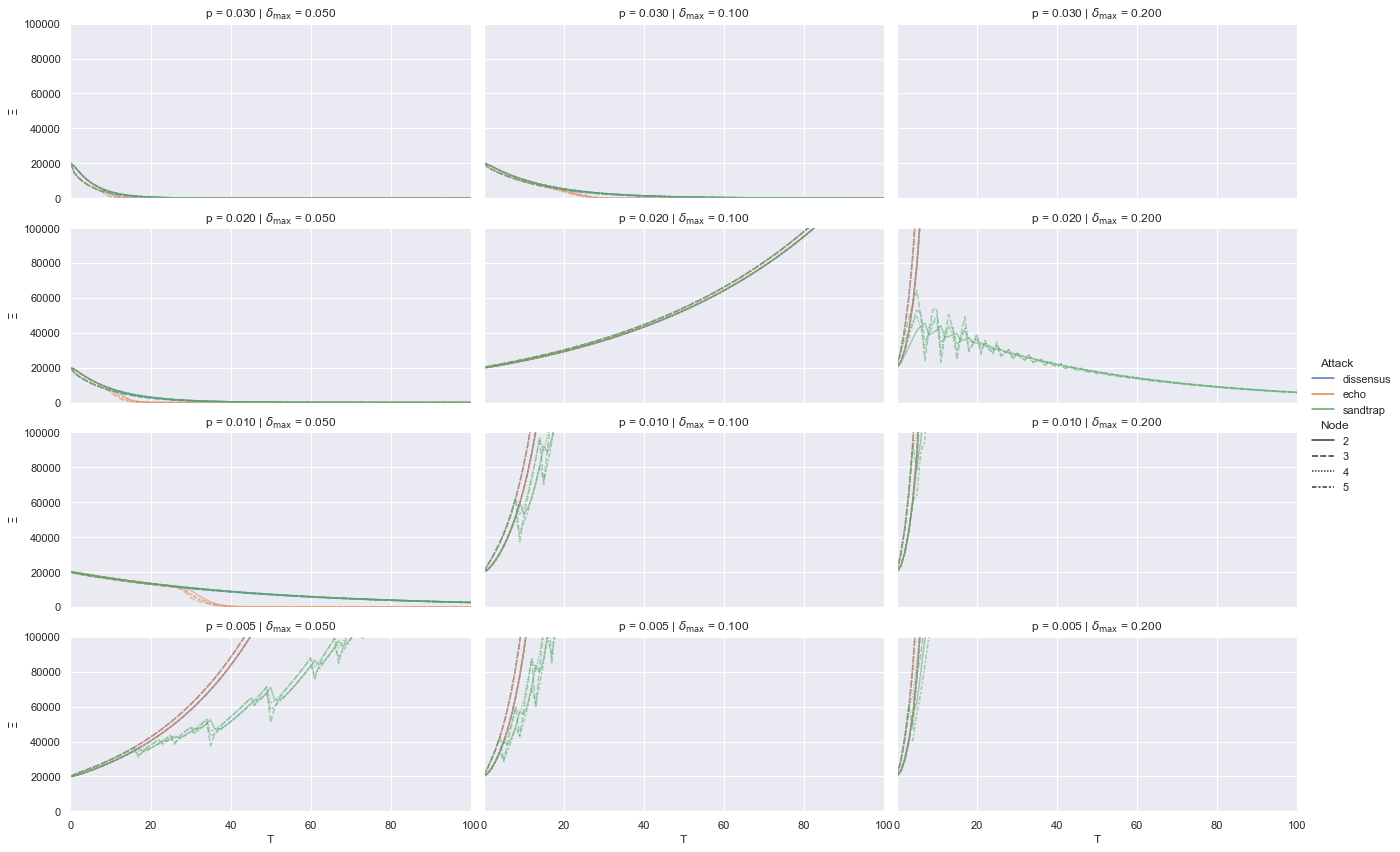

In [25]:
import pandas as pd
import seaborn as sns
stats = []
for res in results:
    delta_max, p = res['exp'].delta_max, res['exp'].p
    if delta_max > 0.3 or res['beta'] > 0.268 or res['beta'] < 0.08:
        continue

    for t, e, cds in zip(range(res['exp'].T+1), res['exp'].errors, res['exp'].consensus_distances):
        if t > 100:
            break
        for i in range(len(cds)):
            stats.append({r"$\delta_{\max}$ value": delta_max, "p_value": p, "Error": e, r"$\Xi$": cds[i], "T": t, "Attack": res['attack'], "Node": i+2})


plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 11
sns.set(rc={'figure.figsize': (6.75, 3)})

df = pd.DataFrame(stats)
df['p'] = df['p_value'].apply(lambda x: "{:.3f}".format(x))
df[r"$\delta_{\max}$"] = df[r"$\delta_{\max}$ value"].apply(lambda x: "{:.3f}".format(x))
g = sns.relplot(data=df, x="T", y=r"$\Xi$", col=r"$\delta_{\max}$", row="p", kind='line', hue="Attack", alpha=0.5, style="Node", height=3, aspect=2)

g.set(xlim=(0, 100))
g.set(ylim=(0, 100000))
# g.savefig("./consensus_constant_attack.pdf", bbox_inches="tight", dpi=720)

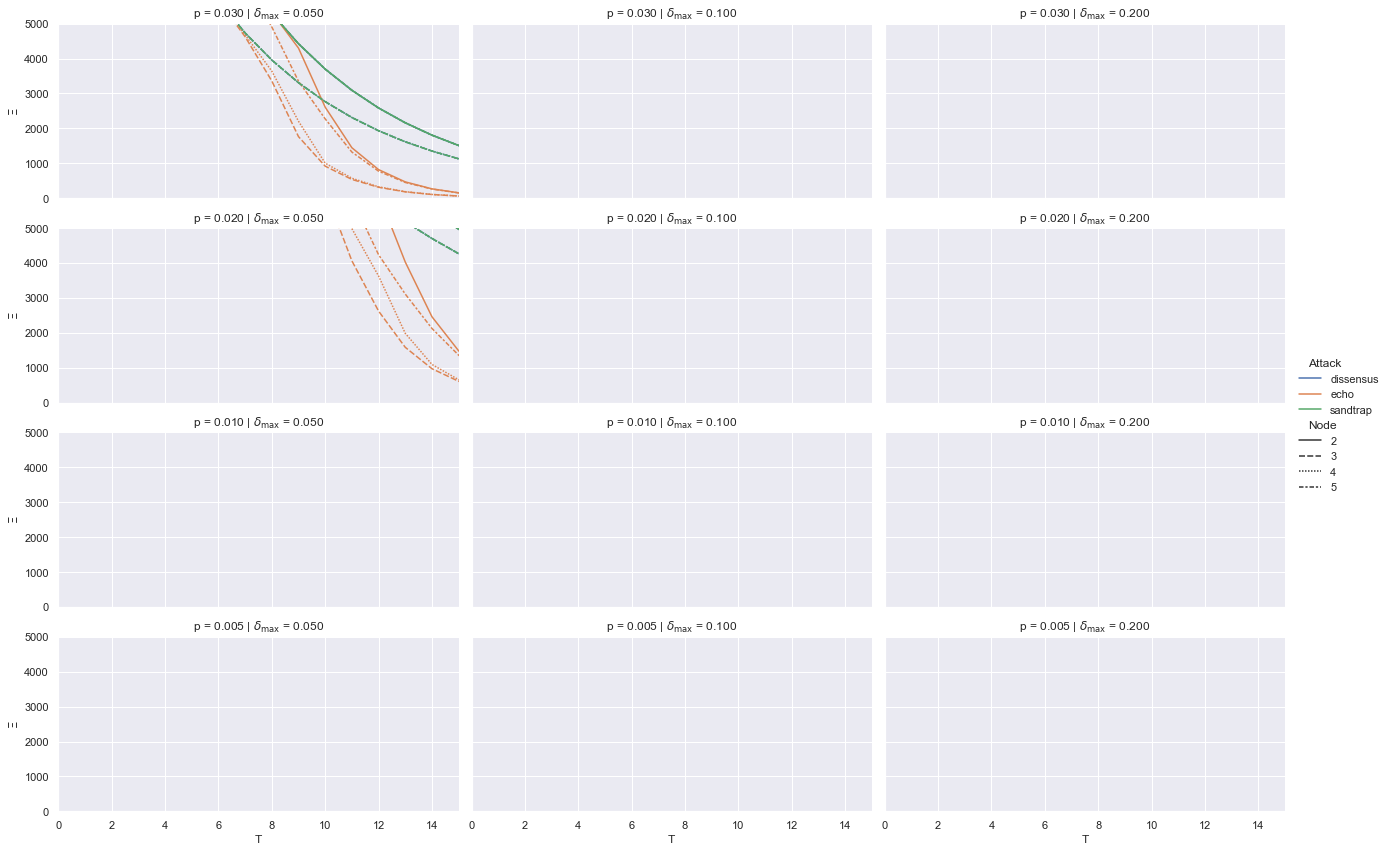

In [26]:
g = sns.relplot(data=df, x="T", y=r"$\Xi$", col=r"$\delta_{\max}$", row="p", kind='line', hue="Attack", style="Node", height=3, aspect=2)

g.set(xlim=(0, 15))
g.set(ylim=(0, 5000))

### Equal weights

In [33]:
N = 6
b = 2
data0 = [[0 for i in range(N)], [0 for i in range(N)], [200 for i in range(N)], [200 for i in range(N)]]

results = []
for attacker, attack_name in [(DissensusAttack(1, N), "dissensus"), 
                              (EchoAttack(1, 1, N), "echo"),
                               (SandTrapAttack(3, N), "sandtrap")]:
    Defense, defense_name = SSClipBis, "SSClip"
    delta_max = 1/5
    mixing = np.array([
        [1/2, 1/2, 0, 0],
        [1/5, 3/5, 1/5, 0],
        [0, 1/5, 3/5, 1/5],
        [0, 0, 1/2, 1/2]
    ])
    p = spectral_gap(mixing) ** 2
    try:
        graph = TunableChain(0, 1/5, mixing, delta_max=delta_max, p=p)
        data_manager = DataManager(data0, graph, attacker)
        runner = Defense(data_manager, graph, N, b, p, delta_max, 100)
        runner.run()
        results.append({"exp": runner, "attack": attack_name, "defense": defense_name, 'beta': 1/5})
    except:
        pass
print(graph.metropolis_weight[2:])

[[0.  0.  0.5 0.5 0.  0. ]
 [0.2 0.2 0.2 0.2 0.2 0. ]
 [0.2 0.2 0.  0.2 0.2 0.2]
 [0.  0.  0.  0.  0.5 0.5]]


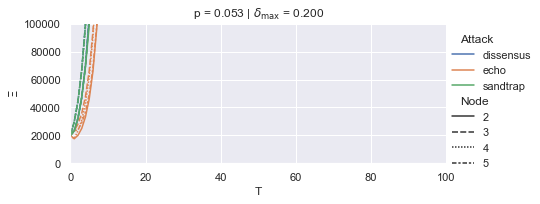

In [42]:
import pandas as pd
import seaborn as sns
stats = []
for res in results:
    delta_max, p = res['exp'].delta_max, res['exp'].p
    if delta_max > 0.3 or res['beta'] > 0.268 or res['beta'] < 0.08:
        continue

    for t, e, cds in zip(range(res['exp'].T+1), res['exp'].errors, res['exp'].consensus_distances):
        if t > 100:
            break
        for i in range(len(cds)):
            stats.append({r"$\delta_{\max}$ value": delta_max, "p_value": p, "Error": e, r"$\Xi$": cds[i], "T": t, "Attack": res['attack'], "Node": i+2})


plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 11
sns.set(rc={'figure.figsize': (20, 10)})

df = pd.DataFrame(stats)
df['p'] = df['p_value'].apply(lambda x: "{:.3f}".format(x))
df[r"$\delta_{\max}$"] = df[r"$\delta_{\max}$ value"].apply(lambda x: "{:.3f}".format(x))
g = sns.relplot(data=df, x="T", y=r"$\Xi$", col=r"$\delta_{\max}$", row="p", kind='line', hue="Attack", style="Node", height=3, aspect=2)

g.set(xlim=(0, 100))
g.set(ylim=(0, 100000))
# g.savefig("./consensus_constant_attack.pdf", bbox_inches="tight", dpi=720)

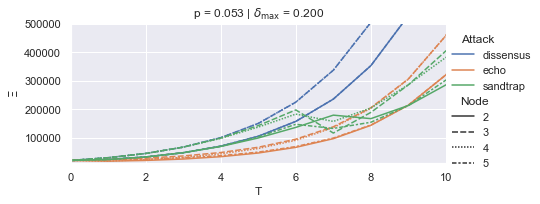

In [48]:
g = sns.relplot(data=df, x="T", y=r"$\Xi$", col=r"$\delta_{\max}$", row="p", kind='line', hue="Attack", style="Node", height=3, aspect=2)

g.set(xlim=(0, 10))
g.set(ylim=(10000, 500000))

### Excluding self node

In [29]:
N = 6
b = 2
data0 = [[0 for i in range(N)], [0 for i in range(N)], [200 for i in range(N)], [200 for i in range(N)]]

results = []
for attacker, attack_name in [(ConstValueAttack(0, 200, N), "constant"), (DissensusAttack(1, N), "dissensus"), 
                              (RandomAttack(-200,200, N), "random"), (EchoAttack(1, 1, N), "echo"),
                              (RandomConsistentAttack(-200,200,N), "consistent"), 
                              (InconsistentAttack(-200, 200, N), "inconsistent"), (SandTrapAttack(3, N), "sandtrap")]:
    Defense, defense_name = SSClipBis, "SSClip"
    delta_max = 1/4
    mixing = np.array([
        [0, 1, 0, 0],
        [1/4, 2/4, 1/4, 0],
        [0, 1/4, 2/4, 1/4],
        [0, 0, 1, 0]
    ])
    p = spectral_gap(mixing) ** 2
    try:
        graph = TunableChain(0, 0, mixing, delta_max=delta_max, p=p)
        data_manager = DataManager(data0, graph, attacker)
        runner = Defense(data_manager, graph, N, b, p, delta_max, 100)
        runner.run()
        results.append({"exp": runner, "attack": attack_name, "defense": defense_name, 'beta': 1/4})
    except:
        pass


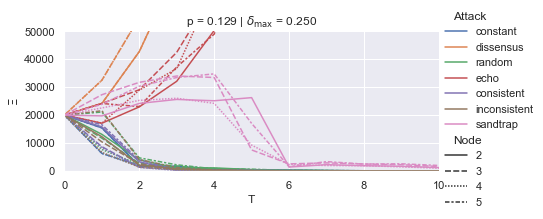

In [30]:
import pandas as pd
import seaborn as sns
stats = []
for res in results:
    delta_max, p = res['exp'].delta_max, res['exp'].p
    if delta_max > 0.3 or res['beta'] > 0.268 or res['beta'] < 0.08:
        continue

    for t, e, cds in zip(range(res['exp'].T+1), res['exp'].errors, res['exp'].consensus_distances):
        if t > 100:
            break
        for i in range(len(cds)):
            stats.append({r"$\delta_{\max}$ value": delta_max, "p_value": p, "Error": e, r"$\Xi$": cds[i], "T": t, "Attack": res['attack'], "Node": i+2})


plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 11
sns.set(rc={'figure.figsize': (6.75, 3)})

df = pd.DataFrame(stats)
df['p'] = df['p_value'].apply(lambda x: "{:.3f}".format(x))
df[r"$\delta_{\max}$"] = df[r"$\delta_{\max}$ value"].apply(lambda x: "{:.3f}".format(x))
g = sns.relplot(data=df, x="T", y=r"$\Xi$", col=r"$\delta_{\max}$", row="p", kind='line', hue="Attack", style="Node", height=3, aspect=2)

g.set(xlim=(0, 10))
g.set(ylim=(0, 50000))
# g.savefig("./consensus_constant_attack.pdf", bbox_inches="tight", dpi=720)